# Testing the Florence 2 fine tuned model for object detection
Models: 
- https://huggingface.co/microsoft/Florence-2-large
- https://huggingface.co/microsoft/Florence-2-base

Document: https://arxiv.org/abs/2311.06242

<img src="florence2_1.jpg">

<img src="florence2_2.jpg">

In [1]:
import os
import sys
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from transformers import (AutoModelForCausalLM, AutoProcessor)

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

## 1. Functions

In [3]:
def calling_florence2_model(model_id, img, text_input=None):
    """
    Calls the Microsoft Florence2 model to perform object detection on an image and prints the results.

    Args:
        model_id (str): The identifier for the pre-trained model.
        img (ndarray): The image on which to perform object detection.
        text_input (str, optional): Additional text input to be appended to the task prompt. 
        Default is None.

    Returns:
        dict: A dictionary containing the object detection results, including bounding boxes and labels.
    """
    task_prompt = '<OD>'
    prompt = task_prompt if text_input is None else task_prompt + text_input
    
    model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
    inputs = processor(text=prompt, images=img, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    results = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(img.width, img.height))

    bboxes = results['<OD>']['bboxes']
    labels = results['<OD>']['labels']

    print(f"\033[1;31;34mDetected objects using {model_id}\n")
    
    for idx, (bbox, label) in enumerate(zip(bboxes, labels), start=1):
        print(f"{idx:3}: Detected object: {label:25} | Bounding Box: {bbox}")

    print(f"\nTotal number of detected objects = {len(labels)}")

    print("\033[0m")
    print(results)

    return results['<OD>']

In [4]:
def display_bbox(img, data, color1="lime"):
    """
    Displays an image with bounding boxes and labels.

    Args:
        image (ndarray): The image on which to plot the bounding boxes.
        data (dict): A dictionary containing:
            - 'bboxes' (list of tuples): A list of bounding boxes, where each bounding box is
            represented as a tuple (x1, y1, x2, y2).
            - 'labels' (list of str): A list of labels corresponding to each bounding box.

    Returns:
        None: This function displays the image with bounding boxes and labels plotted on it.
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(img)

    # parameters
    color2 = "red"
    alpha = 0.7
    linewidth = 3
    fontsize = 10

    # Parsing the results
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        ## Bbox
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=linewidth,
                                 edgecolor=color1,
                                 facecolor='none')
        ax.add_patch(rect)
        # Adding text
        plt.text(x1,
                 y1,
                 label,
                 color=color2,
                 fontsize=fontsize,
                 bbox=dict(facecolor=color1, alpha=alpha))

    plt.show()

## 2. Testing

In [5]:
TEST_IMAGES = "test_images"

In [6]:
MODEL_DIR = "model_checkpoints"
os.listdir(MODEL_DIR)

['epoch_1',
 'epoch_10',
 'epoch_2',
 'epoch_3',
 'epoch_4',
 'epoch_5',
 'epoch_6',
 'epoch_7',
 'epoch_8',
 'epoch_9']

In [7]:
ft_model =  os.path.join(MODEL_DIR, "epoch_10")  # Our fine tuned model to use
base_model = 'microsoft/Florence-2-base'  # or 'microsoft/Florence-2-large'

### Test 1

#### Initial image

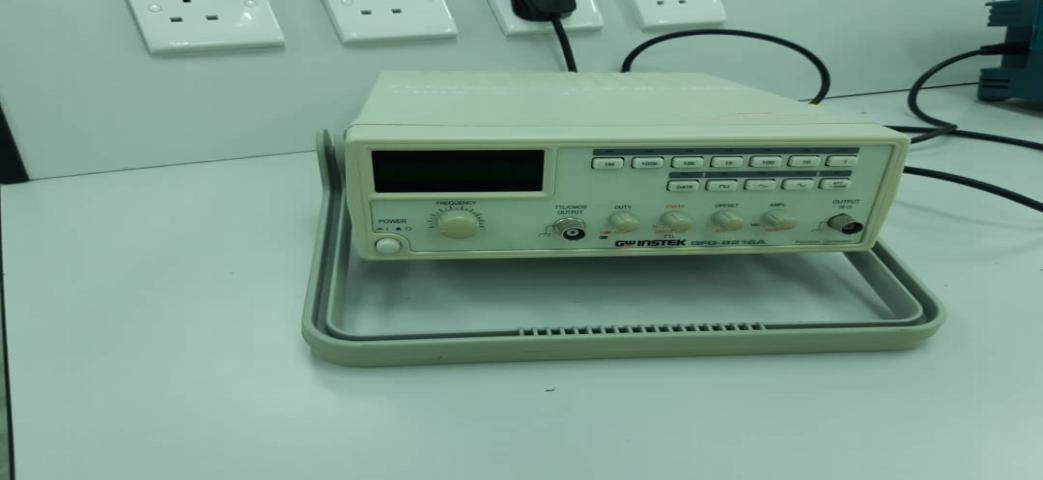

In [8]:
test_image = os.path.join(TEST_IMAGES, 'test1.jpg')

img = Image.open(test_image)
img

#### Fine tuned model

In [9]:
model_id = ft_model

results = calling_florence2_model(model_id, img)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Detected objects using model_checkpoints/epoch_10

  1: Detected object: Digital Multimeter        | Bounding Box: [298.8194885253906, 67.91999816894531, 946.5224609375, 367.91998291015625]

Total number of detected objects = 1

{'<OD>': {'bboxes': [[298.8194885253906, 67.91999816894531, 946.5224609375, 367.91998291015625]], 'labels': ['Digital Multimeter']}}


Florence-2 model model_checkpoints/epoch_10


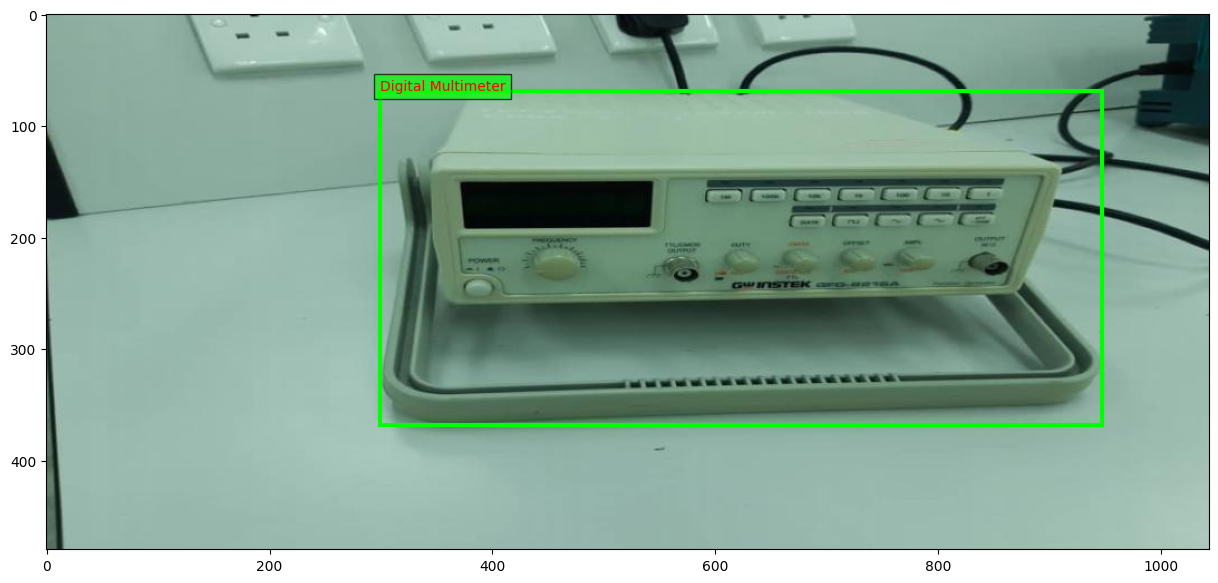

In [10]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results)

#### Base model

In [11]:
model_id = base_model

results = calling_florence2_model(model_id, img)

Detected objects using microsoft/Florence-2-base

  1: Detected object: knob                      | Bounding Box: [436.4954833984375, 210.95999145507812, 481.344482421875, 239.75999450683594]
  2: Detected object: knob                      | Bounding Box: [760.8684692382812, 210.0, 799.45947265625, 232.0800018310547]
  3: Detected object: knob                      | Bounding Box: [658.6544799804688, 211.9199981689453, 694.1165161132812, 233.51998901367188]
  4: Detected object: knob                      | Bounding Box: [710.8045043945312, 210.47999572753906, 746.2664794921875, 232.0800018310547]
  5: Detected object: knob                      | Bounding Box: [827.6204833984375, 214.79998779296875, 865.16845703125, 235.4399871826172]
  6: Detected object: knob                      | Bounding Box: [607.5474853515625, 211.9199981689453, 640.9234619140625, 234.0]
  7: Detected object: power plugs and sockets   | Bounding Box: [124.63849639892578, 0.23999999463558197, 285.260498046875, 54.9

Florence-2 model microsoft/Florence-2-base


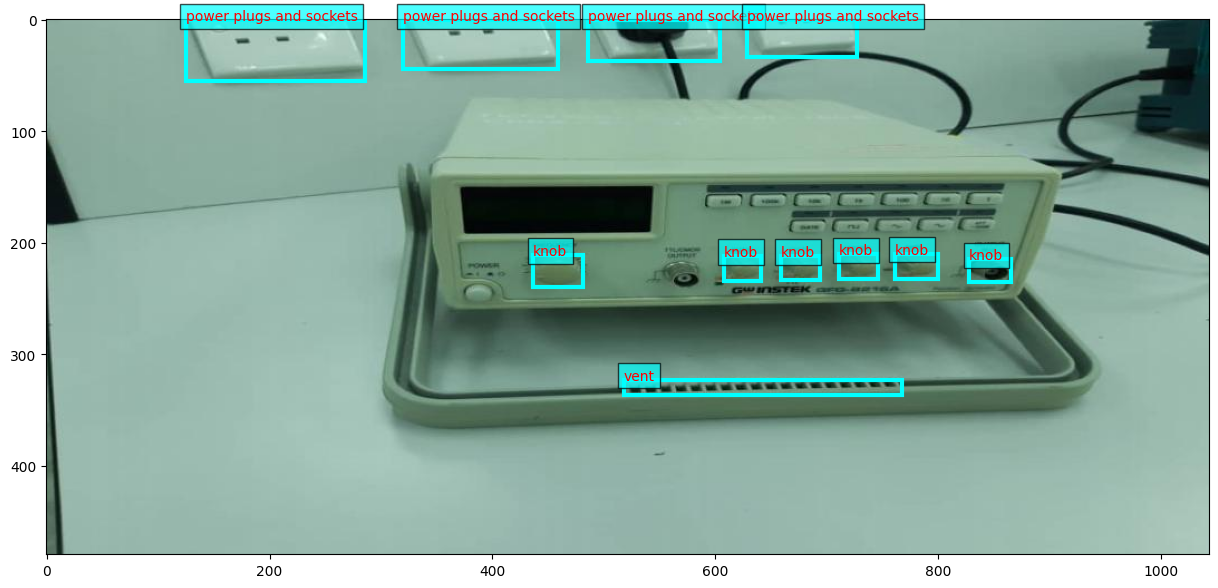

In [12]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results, color1="cyan")

## Test 2

#### Initial image

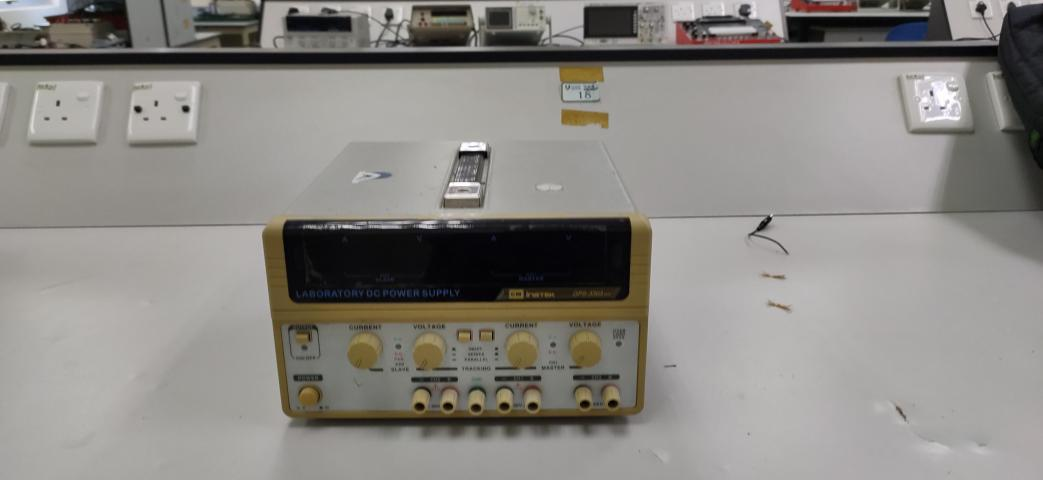

In [13]:
test_image = os.path.join(TEST_IMAGES, 'test2.jpg')

img = Image.open(test_image)
img

#### Fine tuned model

In [14]:
model_id = ft_model

results = calling_florence2_model(model_id, img)

Detected objects using model_checkpoints/epoch_10

  1: Detected object: DC Power Supply           | Bounding Box: [261.271484375, 137.52000427246094, 652.396484375, 421.1999816894531]

Total number of detected objects = 1

{'<OD>': {'bboxes': [[261.271484375, 137.52000427246094, 652.396484375, 421.1999816894531]], 'labels': ['DC Power Supply']}}


Florence-2 model model_checkpoints/epoch_10


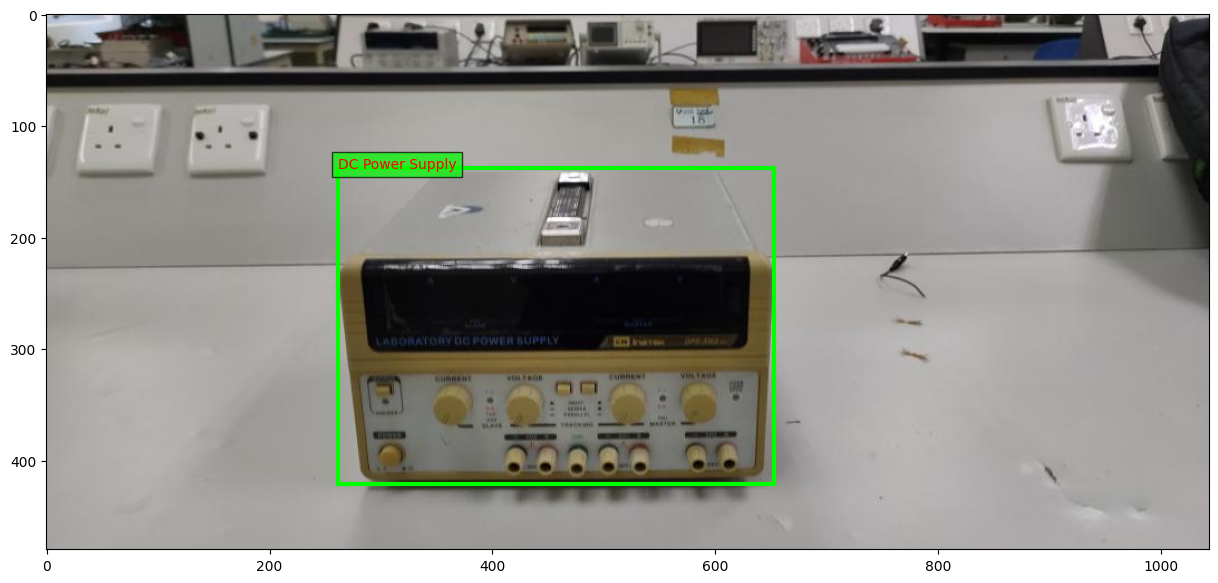

In [15]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results)

#### Base model

In [16]:
model_id = base_model

results = calling_florence2_model(model_id, img)

Detected objects using microsoft/Florence-2-base

  1: Detected object: adhesive tape             | Bounding Box: [561.655517578125, 108.23999786376953, 609.6334838867188, 128.39999389648438]
  2: Detected object: adhesive tape             | Bounding Box: [559.5695190429688, 65.5199966430664, 604.4185180664062, 82.79999542236328]
  3: Detected object: knob                      | Bounding Box: [346.7974853515625, 331.91998291015625, 383.302490234375, 368.8800048828125]
  4: Detected object: knob                      | Bounding Box: [411.4635009765625, 332.3999938964844, 446.9255065917969, 369.3599853515625]
  5: Detected object: knob                      | Bounding Box: [505.33349609375, 330.9599914550781, 539.7525024414062, 367.91998291015625]
  6: Detected object: knob                      | Bounding Box: [568.9564819335938, 330.47998046875, 603.37548828125, 367.91998291015625]
  7: Detected object: knob                      | Bounding Box: [297.7764892578125, 386.6399841308594, 321.7

Florence-2 model microsoft/Florence-2-base


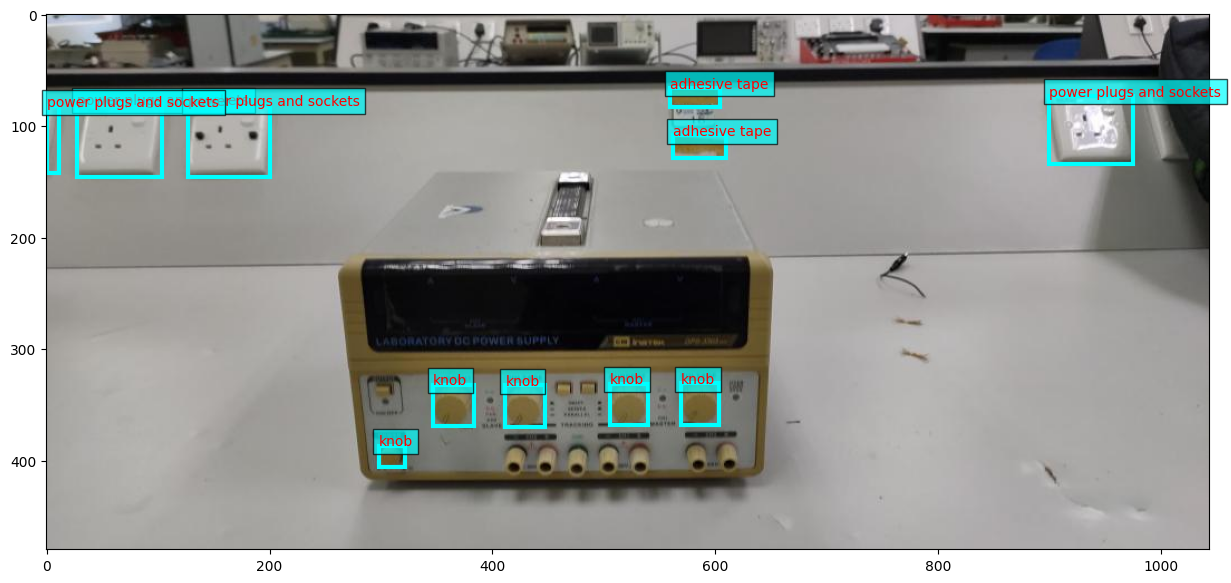

In [17]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results, color1="cyan")

### Test 3

#### Initial image

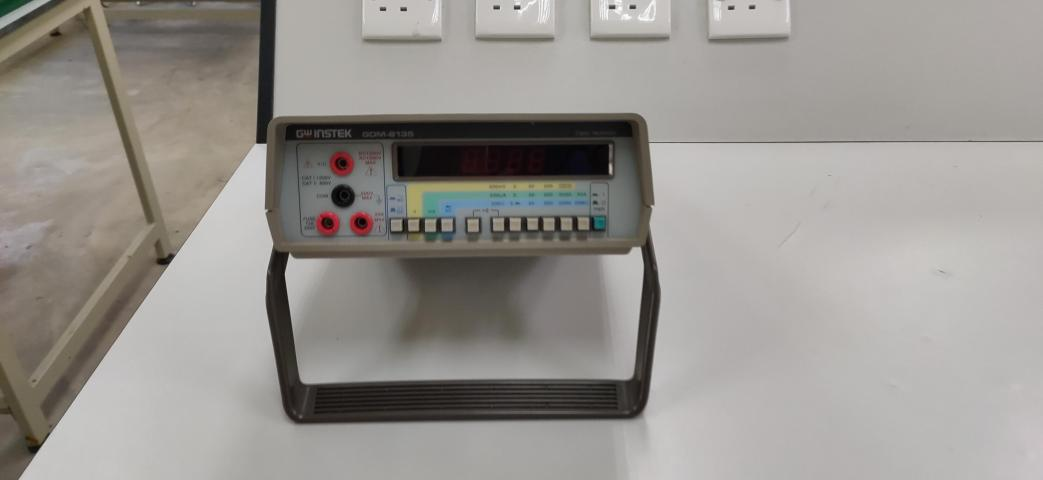

In [18]:
test_image = os.path.join(TEST_IMAGES, 'test3.jpg')

img = Image.open(test_image)
img

#### Fine tuned model

In [19]:
model_id = ft_model

results = calling_florence2_model(model_id, img)

Detected objects using model_checkpoints/epoch_10

  1: Detected object: Digital Multimeter        | Bounding Box: [263.35748291015625, 112.07999420166016, 659.697509765625, 424.0799865722656]

Total number of detected objects = 1

{'<OD>': {'bboxes': [[263.35748291015625, 112.07999420166016, 659.697509765625, 424.0799865722656]], 'labels': ['Digital Multimeter']}}


Florence-2 model model_checkpoints/epoch_10


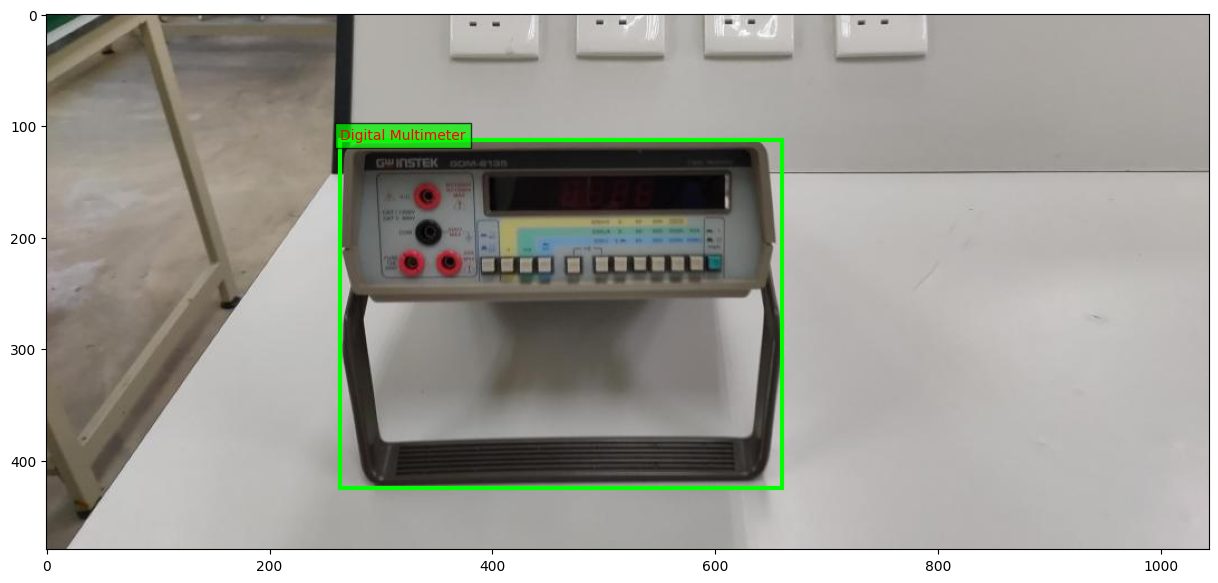

In [20]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results)

#### Base model

In [21]:
model_id = base_model

results = calling_florence2_model(model_id, img)

Detected objects using microsoft/Florence-2-base

  1: Detected object: power plugs and sockets   | Bounding Box: [708.718505859375, 0.23999999463558197, 793.2014770507812, 39.599998474121094]
  2: Detected object: power plugs and sockets   | Bounding Box: [362.4425048828125, 0.23999999463558197, 443.7964782714844, 41.040000915527344]
  3: Detected object: power plugs and sockets   | Bounding Box: [590.8594970703125, 0.23999999463558197, 673.2564697265625, 38.63999938964844]
  4: Detected object: power plugs and sockets   | Bounding Box: [476.1294860839844, 0.23999999463558197, 557.4835205078125, 39.119998931884766]

Total number of detected objects = 4

{'<OD>': {'bboxes': [[708.718505859375, 0.23999999463558197, 793.2014770507812, 39.599998474121094], [362.4425048828125, 0.23999999463558197, 443.7964782714844, 41.040000915527344], [590.8594970703125, 0.23999999463558197, 673.2564697265625, 38.63999938964844], [476.1294860839844, 0.23999999463558197, 557.4835205078125, 39.119998931884

Florence-2 model microsoft/Florence-2-base


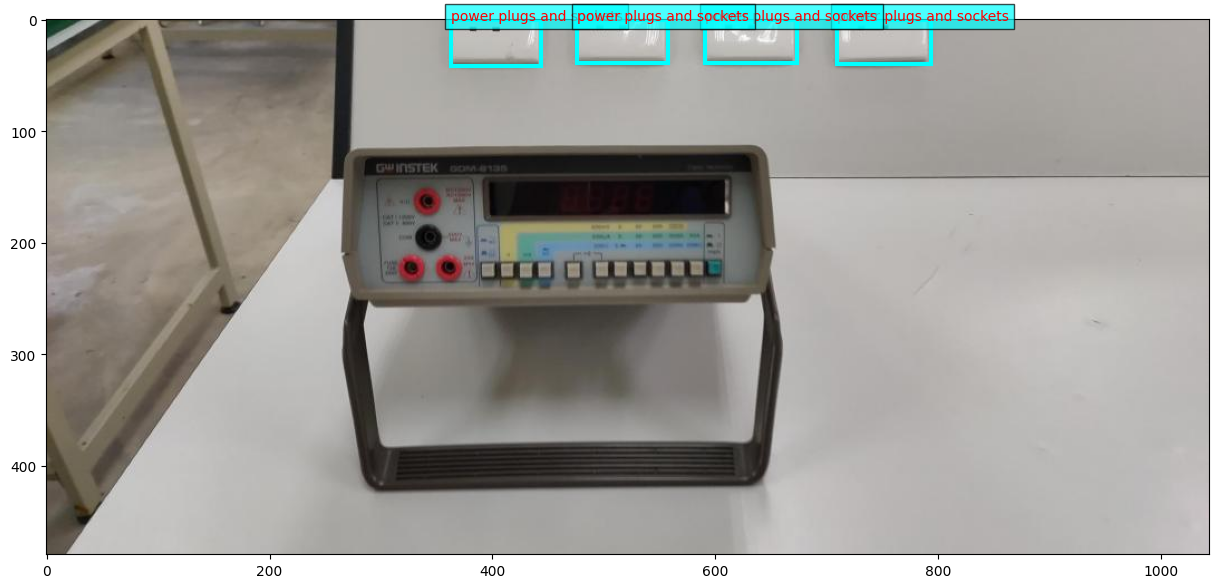

In [22]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results, color1="cyan")

### Test 4

#### Initial image

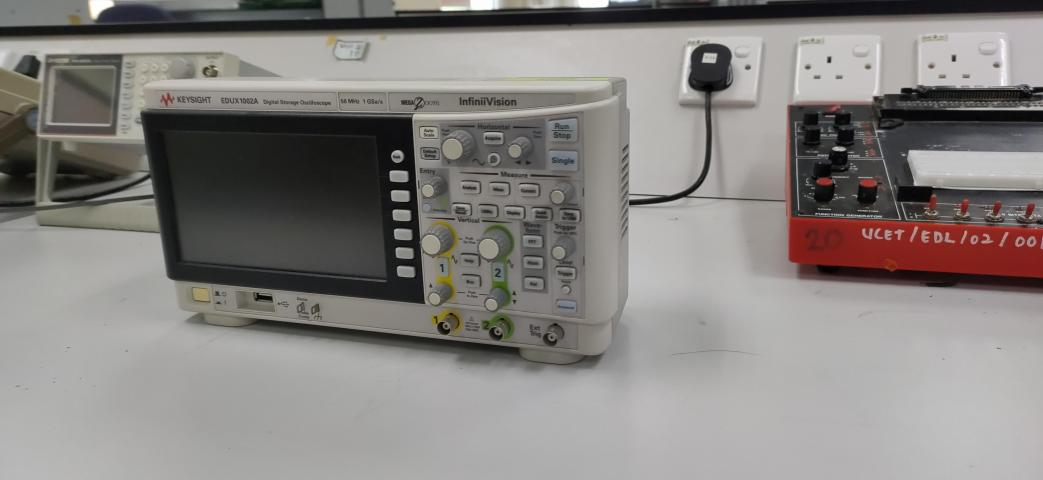

In [23]:
test_image = os.path.join(TEST_IMAGES, 'test4.jpg')

img = Image.open(test_image)
img

#### Fine tuned model

In [24]:
model_id = ft_model

results = calling_florence2_model(model_id, img)

Detected objects using model_checkpoints/epoch_10

  1: Detected object: Oscilloscope              | Bounding Box: [139.24049377441406, 75.5999984741211, 630.4934692382812, 365.03997802734375]

Total number of detected objects = 1

{'<OD>': {'bboxes': [[139.24049377441406, 75.5999984741211, 630.4934692382812, 365.03997802734375]], 'labels': ['Oscilloscope']}}


Florence-2 model model_checkpoints/epoch_10


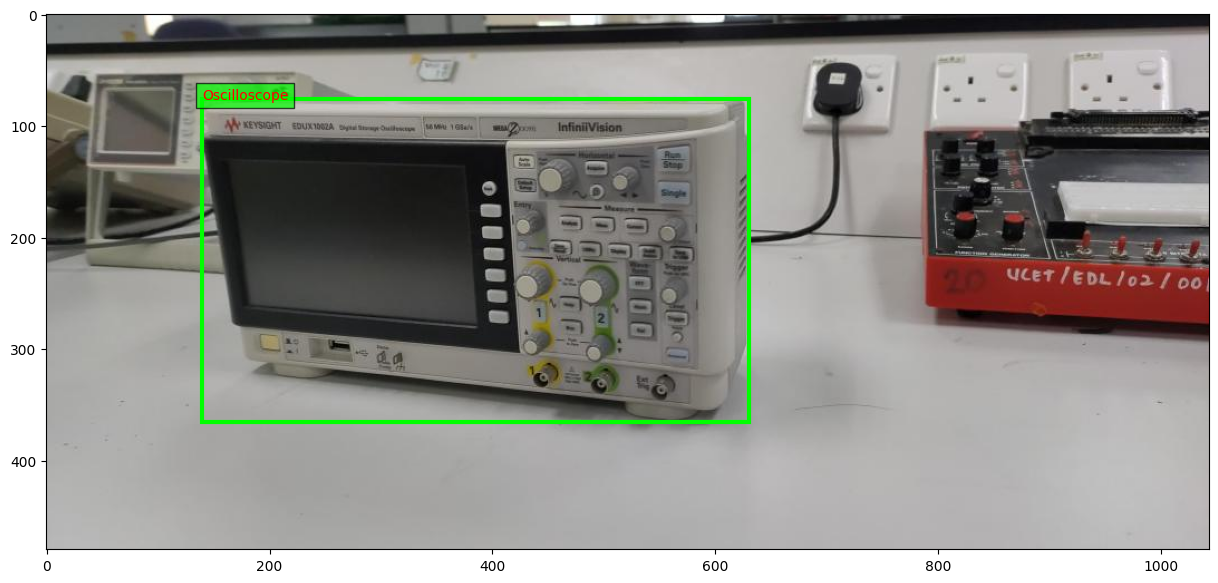

In [25]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results)

#### Base model

In [26]:
model_id = base_model

results = calling_florence2_model(model_id, img)

Detected objects using microsoft/Florence-2-base

  1: Detected object: chair                     | Bounding Box: [95.43450164794922, 4.079999923706055, 178.87449645996094, 22.799999237060547]
  2: Detected object: microwave oven            | Bounding Box: [141.3264923095703, 76.08000183105469, 632.5794677734375, 365.03997802734375]
  3: Detected object: power plugs and sockets   | Bounding Box: [793.2014770507812, 34.79999923706055, 882.8994750976562, 104.87999725341797]
  4: Detected object: power plugs and sockets   | Bounding Box: [679.5144653320312, 36.23999786376953, 765.0404663085938, 106.79999542236328]
  5: Detected object: power plugs and sockets   | Bounding Box: [917.3184814453125, 31.920000076293945, 1011.1884765625, 87.1199951171875]

Total number of detected objects = 5

{'<OD>': {'bboxes': [[95.43450164794922, 4.079999923706055, 178.87449645996094, 22.799999237060547], [141.3264923095703, 76.08000183105469, 632.5794677734375, 365.03997802734375], [793.2014770507812, 34.

Florence-2 model microsoft/Florence-2-base


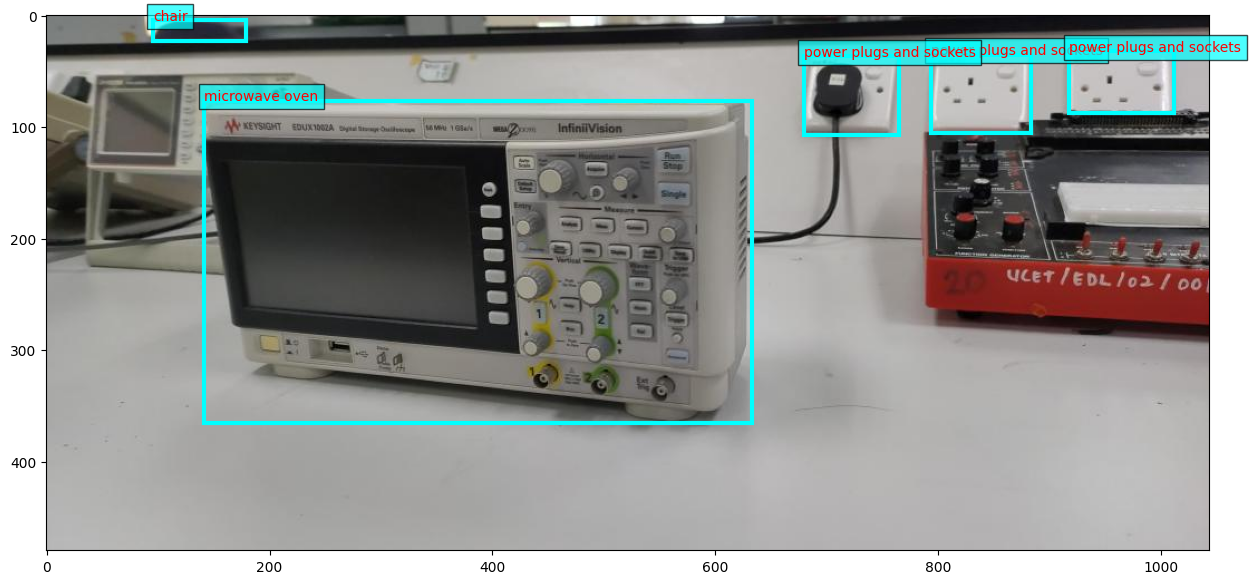

In [27]:
print(f"Florence-2 model {model_id}")
display_bbox(img, results, color1="cyan")